In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/models1/bert_for_classification1.h5
/kaggle/input/models1/tokenizer/tokenizer.json
/kaggle/input/models1/tokenizer/tokenizer_config.json
/kaggle/input/models1/tokenizer/special_tokens_map.json
/kaggle/input/models1/tokenizer/vocab.txt
/kaggle/input/project1-2/tut.csv
/kaggle/input/project1-2/clickbait.csv
/kaggle/input/project1-2/ran.csv
/kaggle/input/project1-2/random_text.csv


In [2]:
dft = pd.read_csv("/kaggle/input/project1-2/tut.csv")
dfr = pd.read_csv("/kaggle/input/project1-2/ran.csv")
dft = dft.dropna()
dfr = dfr.dropna()

* **tut.csv** is supposed to contain only video_titles which are meant to be tutorial of cs topics listed above , but in reality just like every real world dataset it do have some text which should belong to other categories.
* **ran.csv** is supposed to contain only video_titles which are not meant to be tutorial , but in reality it do have some text which should belong to other categories.

* This can cause some problem , and just to quantify that problem we are going to train on this dataset and then will think of some solution for now i am relying on pretrained model own capacity to identify outliers and avoid overfitting.

In [3]:
print(dft.shape,dfr.shape)
print(dft.isnull().sum())
print(dfr.isnull().sum())

(149294, 1) (34711, 1)
video_titles    0
dtype: int64
video_titles    0
dtype: int64


In [6]:
for item in dft.sample(20)["video_titles"]:
    print("@",item)

@ stop using pixelsremspercentages to define widths in css
@ how to display all reserved keywords present in python ? python shortsfeed
@ scan disk scheduling algorithm , scan , animated
@ 27 react js expressions bangla tutorial , react full course
@ 5 how to make a 2d game unity 4 3 tutorial
@ why don t we have better robots yet? , ken goldberg , ted
@ how to make passwords stronger
@ help me make screen shake
@ swap sort explanation , find a duplicate and a missing number
@ bash scripting 6 if and testing explained
@ c program to show the simple example of pointer , c pointers
@ no mana popup message 17 creating a role playing game with unreal engine 4
@ divi image hover plugin image swap on hover effect
@ cs50 2012 week 9, continued
@ building a tutorial in bolt
@ the unknown truth of sap erp, sap event management and sap universal worklist part i
@ build an ecommerce website using react, firebase ( part 3 )
@ reinforcement learning in the openai gym (tutorial) off policy monte carl

In [7]:
for item in dfr.sample(20)["video_titles"]:
    print("@",item)

@ china decoupling the clean network as a trusted network? keith krach at cosm
@ news and community spotlight , may 4, 2023 , unreal engine
@ ram mandir babri masjid dispute explained
@ day 2 wrap up , chris field , global carbon management workshop
@ 01 introduction to teaching aptitude
@ intergalactic (remastered 2009)
@ bcamca ka unfiltered roadmap jo college main bhi nahi bataayenge tanay pratap hindi
@ acid base concepts (arrhenius, lowry bronsted and lewis) in urdu and hindi
@ best of made with unity 172 week of march 17, 2022
@ alec benjamin let me down slowly tevvez remix parallel universe
@ robots teaching themselves to see
@ day 8 monitoring soil moisturization using ask sensor cloud
@ andy rooney, pardon me mr president
@ news and community spotlight , november 17, 2022 , unreal engine
@ overcoming my biggest weakness
@ some tips for interviews 2 , l 2 , fatafat concepts , gate 2022 cse , mita ma am
@ the reality of living in bangalore under rs 30,000 tanay pratap hindi
@ sk

    #i am goint to undersampleing to balance the dataset,so select 40000 rows from tutorial df , such that proportion of length of various text remain same as earlier

In [4]:
# Calculate the length of each text
dft['text_length'] = dft['video_titles'].apply(lambda x: len(x.split()))

In [5]:
dft['text_length'].unique()

array([ 4,  6,  8, 17, 15, 14, 13, 10, 12,  9, 11,  7,  5,  3,  2, 16, 18,
        1, 19, 20, 21, 22, 23, 30, 25, 24, 27, 26, 28, 31, 29, 33])

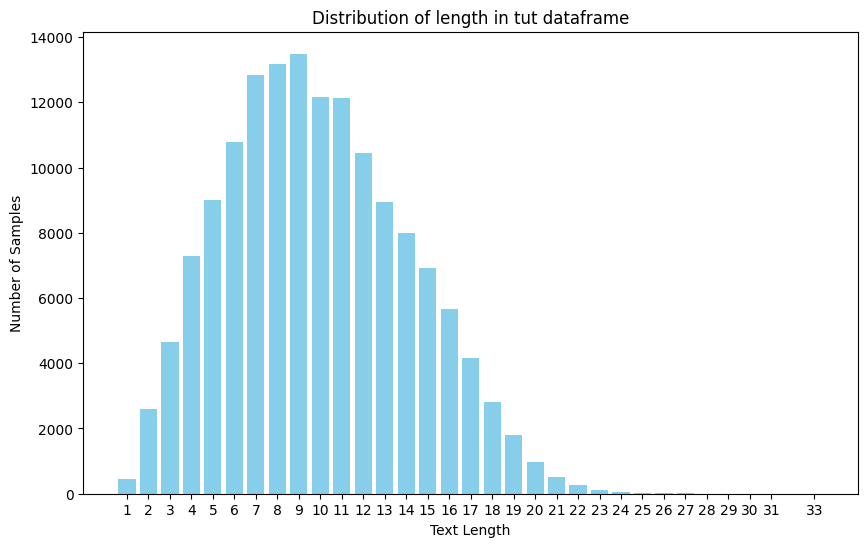

In [6]:
# Extract lengths and number of samples
lengths = (dft['text_length'].value_counts()).index
num_samples = (dft['text_length'].value_counts()).values

# Plotting the bar graph
plt.figure(figsize=(10, 6))
plt.bar(lengths, num_samples, color='skyblue')

# Adding titles and labels
plt.xlabel('Text Length')
plt.ylabel('Number of Samples')
plt.title('Distribution of length in tut dataframe')
plt.xticks(lengths)  # To ensure all lengths are shown on the x-axis

# Show the plot
plt.show()

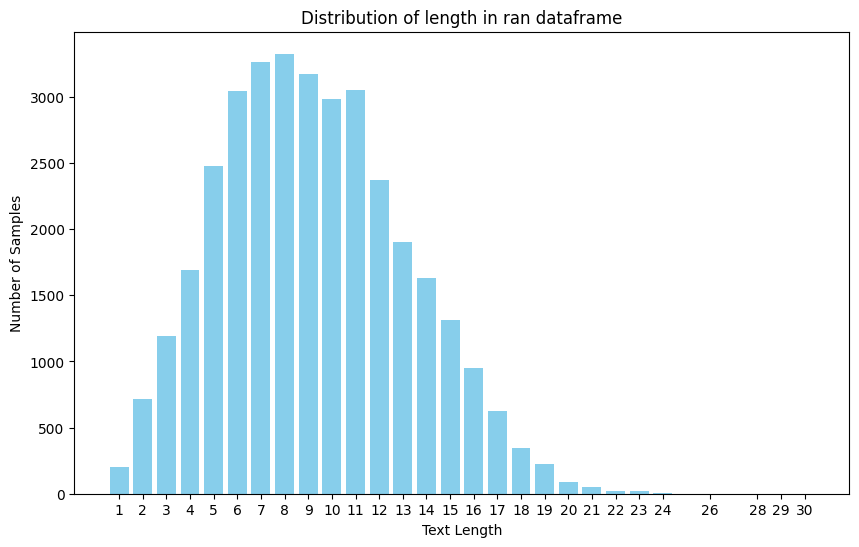

In [7]:
len_vs_frq_rand = (dfr['video_titles'].apply(lambda x: len(x.split()))).value_counts()

lengths = len_vs_frq_rand.index
num_samples = len_vs_frq_rand.values

# Plotting the bar graph
plt.figure(figsize=(10, 6))
plt.bar(lengths, num_samples, color='skyblue')

# Adding titles and labels
plt.xlabel('Text Length')
plt.ylabel('Number of Samples')
plt.title('Distribution of length in ran dataframe')
plt.xticks(lengths)  # To ensure all lengths are shown on the x-axis

# Show the plot
plt.show()

In [8]:
text_length_distribution = dft['text_length'].value_counts(normalize=True)
num_samples_per_length = (text_length_distribution * 40000).astype(int)

In [9]:
sampled_df = pd.DataFrame(columns=dft.columns)  # Ensure the columns are consistent

# Perform stratified sampling for each text length
for length, num_samples in num_samples_per_length.items():
    # Filter the DataFrame for rows with the current text length
    subset_df = dft[dft['text_length'] == length]
    
    # Randomly select the required number of samples
    sampled_subset_df = subset_df.sample(n=num_samples, random_state=42)
    
    # Append the sampled subset to the sampled DataFrame
    sampled_df = pd.concat([sampled_df, sampled_subset_df])

# Drop the text_length column as it's no longer needed
sampled_df.drop(columns='text_length', inplace=True)

# Reset the index of the sampled DataFrame
sampled_df.reset_index(drop=True, inplace=True)

In [10]:
print(sampled_df.shape)
sampled_df.sample(10)

(39983, 1)


,video_titles
28317,a adir variables de javascript en html (curso ...
16171,"20 5 create navbar right side menu , , hm nayem"
16628,simple mail transfer protocol (smtp) and inter...
18067,the biggest blockchain trend of 2020?
14259,"pamerin project kalian , discord project showc..."
34345,"coin change combination , module , dynamic pro..."
25538,free professional game development software fo...
1861,"class 11th satellite energy , gravitation , tu..."
30330,gitops ask me anything
1162,flask tutorial web development with python 7 d...


In [11]:
sampled_df['label'] = dft['video_titles'].apply(lambda x: 1)
dfr['label'] = dfr['video_titles'].apply(lambda x: 0)

    # concatenating tutorial df and random df together

In [12]:
df = pd.concat([sampled_df, dfr])

In [13]:
# Shuffle the concatenated DataFrame
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
print(df['label'].value_counts())
df.sample(5)

label
1    39983
0    34711
Name: count, dtype: int64


,video_titles,label
52969,electro magnetics theory right hand rule,1
6481,10 largest number in k swaps code and time com...,1
11262,divi theme hover effects slide up image on hover,1
62564,earn more study less get learning secrets,0
25060,"diabetes prediction app, six months complete c...",1


In [14]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['label'])  # Features
y = df['label']                 # Target

X = list(X["video_titles"])
y = list(y)

# Fine-Tuneing the Model

In [16]:
from transformers import TFAutoModel, AutoTokenizer
import tensorflow as tf

In [18]:
model = TFAutoModel.from_pretrained("bert-base-uncased")
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [19]:
inputs = tokenizer(X, padding=True, truncation=True)

In [20]:
import tensorflow as tf
dataset = tf.data.Dataset.from_tensor_slices(({
    'input_ids': inputs['input_ids'],
    'attention_mask': inputs['attention_mask'],
    'token_type_ids': inputs['token_type_ids']
}, y))

# Shuffle and batch the dataset
dataset = dataset.shuffle(len(X))
dataset = dataset.batch(8)

# Cache the dataset for better performance
dataset = dataset.cache()
dataset = dataset.prefetch(4)

In [21]:
train = dataset.take(int(len(dataset)*0.8))
test = dataset.skip(int(len(dataset)*0.8)).take(int(len(dataset)*0.2))

In [120]:
from collections import Counter
def get_label_distribution(dataset):
    label_counts = Counter()
    
    for batch in dataset:
        labels = batch[1].numpy()  # Get the labels
        label_counts.update(labels)
    
    return label_counts

In [123]:
train_label_distribution = get_label_distribution(train)
test_label_distribution = get_label_distribution(test)

print("Train label distribution:", train_label_distribution)
print("Test label distribution:", test_label_distribution)

Train label distribution: Counter({1: 31924, 0: 27828})
Test label distribution: Counter({1: 7993, 0: 6943})


In [124]:
class BERTForClassification(tf.keras.Model):
    
    def __init__(self, bert_model, num_classes):
        super().__init__()
        self.bert = bert_model
        self.fc = tf.keras.layers.Dense(num_classes, activation='softmax')
        
    def call(self, inputs):
        x = self.bert(inputs)[1]
        return self.fc(x)

In [125]:
classifier = BERTForClassification(model, num_classes=2)

classifier.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [127]:
history = classifier.fit(
    train,
    epochs=5
)

In [28]:
# Step 2: Evaluate the model on test data
test_loss, test_accuracy = classifier.evaluate(test)
print(f'Test Accuracy: {test_accuracy:.4f}')

1867/1867 [==============================] - 100s 37ms/step - loss: 0.1452 - accuracy: 0.9592
Test Accuracy: 0.9592


In [30]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
y_true = []
y_pred = []

for batch in test:
    inputs, labels = batch
    predictions = classifier.predict(inputs)

    predicted_classes = tf.argmax(predictions, axis=1).numpy()
    true_classes = labels.numpy()

    y_true.extend(true_classes)
    y_pred.extend(predicted_classes)

1/1 [==============================] - 0s 57ms/step


In [33]:
# Calculate precision, recall, and F1-score for each class
precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average=None)

# Display results for each class
for i, (p, r, f, s) in enumerate(zip(precision, recall, f1, support)):
    print(f"Class {i}:")
    print(f"  Precision: {p:.2f}")
    print(f"  Recall: {r:.2f}")
    print(f"  F1-Score: {f:.2f}")
    print(f"  Support: {s}")

# Overall accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"\nOverall Accuracy: {accuracy:.2f}")

Class 0:
  Precision: 0.95
  Recall: 0.96
  F1-Score: 0.96
  Support: 6880
Class 1:
  Precision: 0.96
  Recall: 0.96
  F1-Score: 0.96
  Support: 8056

Overall Accuracy: 0.96
